# 1) Import Libraries and Setup

**Purpose:**  
- Import deep learning frameworks (PyTorch, TorchVision).  
- Load image processing and enhancement utilities (NumPy, OpenCV, PIL, Matplotlib).  
- Bring in helper functions:  
  - `dehaze_image`, `enhance_image`, `compute_mse`, `unsharp_mask`, `smooth_image`.  
- Import model classes:  
  - `StochasticVAE`, `VAE`, `BetaVAE`, `DFCVAE`.  
- Use **torchview** to visualize neural network architectures.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import cv2

from torchvision import transforms
from torchvision.utils import save_image, make_grid

from functions import dehaze_image, enhance_image, compute_mse, unsharp_mask, smooth_image
from model_classes.StochasticVAE import StochasticVAE
from model_classes.VAE import VAE
from model_classes.BetaVAE import BetaVAE
from model_classes.DFCVAE import DFCVAE

from torchview import draw_graph


In [ ]:
import os
print(os.getcwd())


d:\FaceGen-VAE\facegen-env\Scripts


# 2) Check PyTorch and CUDA Environment

**Purpose:**  
- Print PyTorch and CUDA versions.  
- Verify if CUDA (GPU support) is available.  
- Display GPU details (name and number of devices) if available.  
- Define the computing `device` variable (`cuda` if available, otherwise `cpu`).



In [ ]:


print("PyTorch version:", torch.__version__)
print("CUDA runtime version:", torch.version.cuda)
print("Is CUDA available?", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.6.0+cu124
CUDA runtime version: 12.4
Is CUDA available? True
GPU name: NVIDIA GeForce GTX 1660 Ti
Number of GPUs: 1


# 3) Load Pretrained VAE Model

**Purpose:**  
- Define the checkpoint path (`CKPT_PATH`) to the pretrained model file.  
- Initialize the `VAE` model with a latent dimension of 200.  
- Load the model weights from the checkpoint into the initialized VAE.  
- Move the model to the selected `device` (CPU/GPU).  
- Set the model to **evaluation mode** using `model.eval()`.  
- Print the model architecture to confirm successful loading.


In [ ]:
CKPT_PATH = 'D:/FaceGen-VAE/facegen-env/Scripts/models/vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth' 


model = VAE(latent_dim=200).to(device)
checkpoint = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=4096, out_features=200, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=200, bias=True)
  (decoder_input): Linear(in_features=200, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2)

# 4) Visualize Model Architecture

**Purpose:**  
- Use **torchview** to generate a computational graph of the loaded VAE model.  
- Specify the expected input size `(1, 3, 64, 64)` corresponding to a batch of RGB images with resolution 64×64.  
- Display the model architecture for inspection and verification.



(process:11092): Pango-WARNING **: 07:57:22.017: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


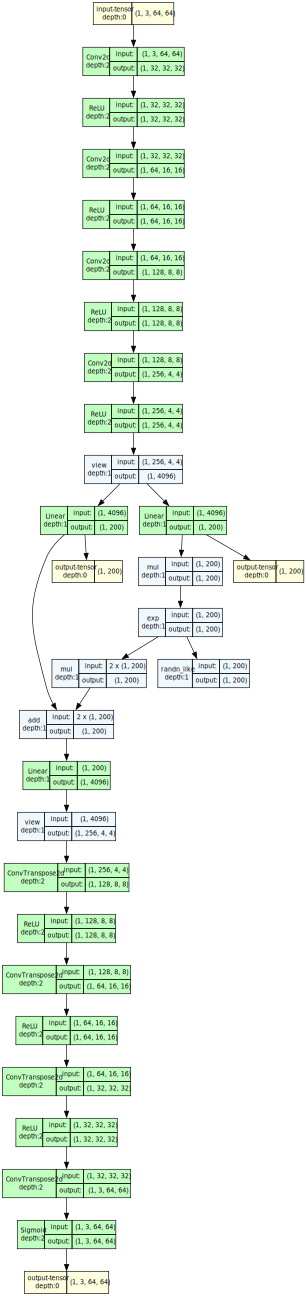

In [ ]:


graph = draw_graph(model, input_size=(1, 3, 64, 64))
graph.visual_graph


# 5) Load Pretrained StochasticVAE Model

Here we’re trying out a different flavor of the VAE — the **StochasticVAE**.  
We point it to the same checkpoint file, push it to the right device (CPU/GPU), and switch it into evaluation mode.  
Finally, we print out the whole architecture just to double-check that everything loaded up correctly.


In [ ]:
CKPT_PATH = 'D:/FaceGen-VAE/facegen-env/Scripts/models/vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth'


model_Stochastic = StochasticVAE(latent_dim=200).to(device)
checkpoint = torch.load(CKPT_PATH, map_location=device)
model_Stochastic.load_state_dict(checkpoint)
model_Stochastic.eval()

print(model_Stochastic)

StochasticVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=4096, out_features=200, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=200, bias=True)
  (decoder_input): Linear(in_features=200, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), str

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 64, 64))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,568
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          32,832
              ReLU-4           [-1, 64, 16, 16]               0
            Conv2d-5            [-1, 128, 8, 8]         131,200
              ReLU-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]         524,544
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 200]         819,400
           Linear-10                  [-1, 200]         819,400
           Linear-11                 [-1, 4096]         823,296
  ConvTranspose2d-12            [-1, 128, 8, 8]         524,416
             ReLU-13            [-1, 128, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

In [ ]:
summary(model_Stochastic, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,568
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          32,832
              ReLU-4           [-1, 64, 16, 16]               0
            Conv2d-5            [-1, 128, 8, 8]         131,200
              ReLU-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]         524,544
              ReLU-8            [-1, 256, 4, 4]               0
            Linear-9                  [-1, 200]         819,400
           Linear-10                  [-1, 200]         819,400
           Linear-11                 [-1, 4096]         823,296
  ConvTranspose2d-12            [-1, 128, 8, 8]         524,416
             ReLU-13            [-1, 128, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

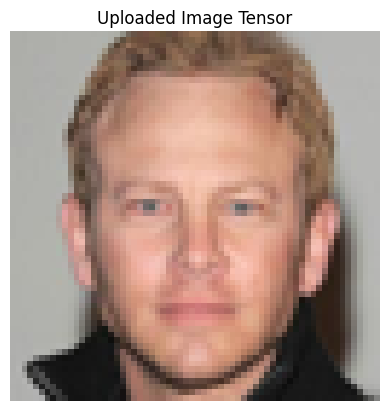

In [ ]:

img_path =  "D:/FaceGen-VAE/facegen-env/Scripts/Images/27994.jpg"
IMAGE_SIZE = 64
img = Image.open(img_path).resize((64,64))
img = np.array(img) / 255.0
img_tensor = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
# Plot the uploaded image tensor
plt.figure()
plt.imshow(img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title("Uploaded Image Tensor")
plt.show()


# 6) Load and Prepare an Input Image

We pick an image from the dataset (in this case, `27994.jpg`) and resize it to **64×64** so it matches what the model expects.  
Then we normalize pixel values to be between 0 and 1, turn it into a PyTorch tensor, and send it off to the chosen device (CPU or GPU).  

Just to be sure everything looks fine, we plot the image again — this time as the processed tensor — with a nice little title on top.


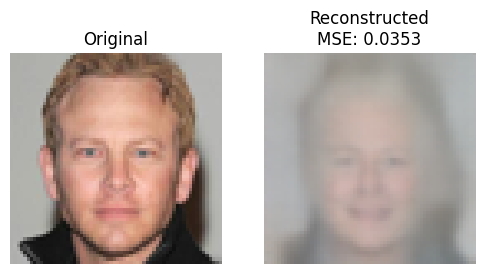

In [ ]:

with torch.no_grad():
    recon, _, _ = model(img_tensor)

mse_recon = F.mse_loss(recon, img_tensor)


orig = img_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
recon = recon.squeeze(0).permute(1,2,0).cpu().numpy()

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].imshow(orig); axs[0].set_title("Original")
axs[1].imshow(recon); axs[1].set_title(f"Reconstructed\nMSE: {mse_recon:.4f}")
for ax in axs: ax.axis("off")
plt.show()

# 8) Enhance the Reconstructed Image

Our VAE’s reconstruction looks good, but VAEs usually make things a bit **blurry**.  
So here we give the generated face a small makeover: we boost the **saturation** and **contrast** to make it pop more. 🎨  

We then compare three versions side by side:  
1. The **original image**  
2. The **raw reconstruction** from the model  
3. The **enhanced reconstruction** with higher contrast and color  

For each one, we also keep track of the **MSE** to see how the enhancement step affects the similarity to the original.


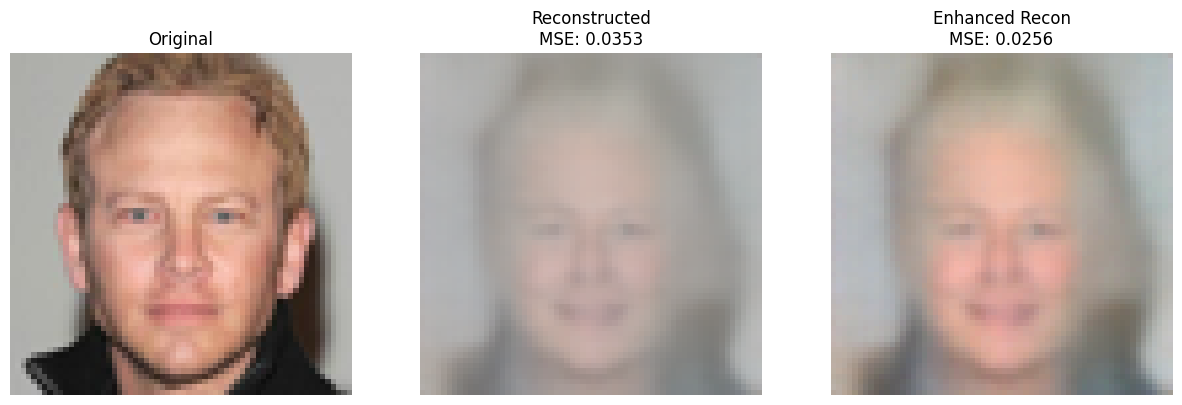

In [ ]:


recon_np = recon.clip(0,1)
orig_np = img_tensor.squeeze(0).permute(1,2,0).cpu().numpy().clip(0,1)

recon_img = Image.fromarray((recon_np*255).astype(np.uint8))


enhanced_img = enhance_image(recon_img, sat=1.5, contrast=1.5)
mse_enhanced = compute_mse(enhanced_img, img_tensor)


fig, axs = plt.subplots(1,3, figsize=(15,5))

# Original
axs[0].imshow(orig_np)
axs[0].set_title("Original")

# Reconstructed
axs[1].imshow(recon_img)
axs[1].set_title(f"Reconstructed\nMSE: {mse_recon:.4f}")

# Reconstructed + Enhancement
axs[2].imshow(enhanced_img)
axs[2].set_title(f"Enhanced Recon\nMSE: {mse_enhanced:.4f}")

for ax in axs:
    ax.axis("off")

plt.show()



# 9) Dehaze the Reconstructed Image

Sometimes reconstructions can look a bit “foggy” or washed out.  
Here we run a **dehazing step** on the reconstructed face to clear things up. After that, we also tweak the saturation and contrast slightly for balance. 🌤️  

We now have four versions side by side:  
1. **Original**  
2. **Raw reconstruction** from the VAE  
3. **Enhanced reconstruction** with boosted contrast & saturation  
4. **Dehazed reconstruction** for a cleaner, sharper look  

Each one shows its **MSE** score so we can see how the modifications affect similarity to the original.


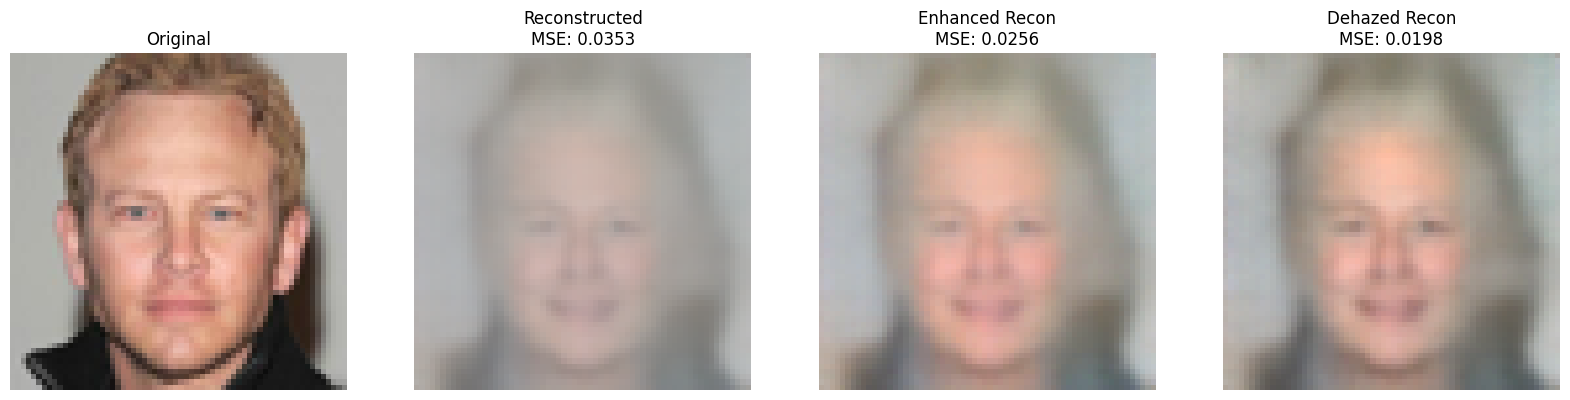

In [ ]:

# ------------------------------
# Dehazed Image
# ------------------------------
recon_np_float = np.array(recon_img)/255.0
J = dehaze_image(recon_np_float)
dehazed_img = Image.fromarray((J*255).astype(np.uint8))
dehazed_img = enhance_image(dehazed_img, sat=1, contrast=1)
mse_dehazed = compute_mse(dehazed_img, img_tensor)

# ------------------------------
# Display the difrances
# ------------------------------
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(orig_np)
axs[0].set_title("Original")

axs[1].imshow(recon_np)
axs[1].set_title(f"Reconstructed\nMSE: {mse_recon:.4f}")

axs[2].imshow(enhanced_img)
axs[2].set_title(f"Enhanced Recon\nMSE: {mse_enhanced:.4f}")

axs[3].imshow(dehazed_img)
axs[3].set_title(f"Dehazed Recon\nMSE: {mse_dehazed:.4f}")

for ax in axs:
    ax.axis("off")
plt.show()


# 10) Final Touch: Smoothing + Unsharp Mask

To polish things up, we apply two final tweaks on the dehazed reconstruction:  
- **Smoothing (bilateral filter):** softens noisy pixels without destroying too much detail.  
- **Unsharp mask:** sharpens edges and makes features like eyes, nose, and mouth stand out more. ✨  

We now compare all five versions side by side:  
1. **Original**  
2. **Raw reconstruction**  
3. **Enhanced reconstruction** (contrast + saturation)  
4. **Dehazed reconstruction**  
5. **Final version** after smoothing + sharpening  

Each panel shows its **MSE** value so we can see how every step impacts similarity to the original face.


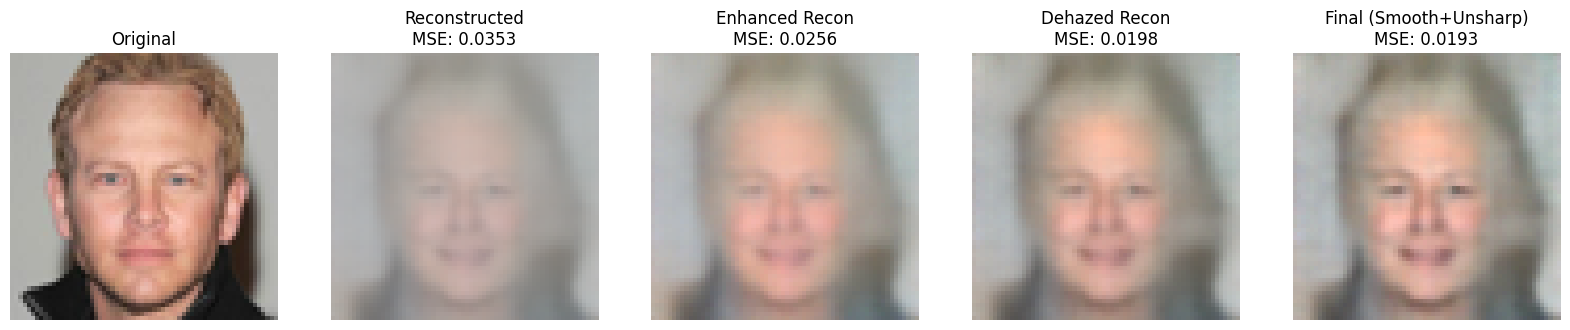

In [ ]:


dehazed_np = np.array(dehazed_img) / 255.0

smooth_img = smooth_image(dehazed_np, method="bilateral", kernel_size=3)



unsharp_np = unsharp_mask(smooth_img, kernel_size=(5,5), sigma=2.0, amount=1.5)
#unsharp_np = smooth_image(unsharp_np, method="bilateral", kernel_size=3)

final_img = Image.fromarray((unsharp_np*255).astype(np.uint8))


mse_final = compute_mse(final_img, img_tensor)

# ------------------------------
# Display the difrances
# ------------------------------
fig, axs = plt.subplots(1,5, figsize=(20,5))
axs[0].imshow(orig_np)
axs[0].set_title("Original")

axs[1].imshow(recon_np)
axs[1].set_title(f"Reconstructed\nMSE: {mse_recon:.4f}")

axs[2].imshow(enhanced_img)
axs[2].set_title(f"Enhanced Recon\nMSE: {mse_enhanced:.4f}")

axs[3].imshow(dehazed_img)
axs[3].set_title(f"Dehazed Recon\nMSE: {mse_dehazed:.4f}")
axs[4].imshow(final_img)
axs[4].set_title(f"Final (Smooth+Unsharp)\nMSE: {mse_final:.4f}")
for ax in axs:
    ax.axis("off")
plt.show()


# 11) Compare Raw vs. Final Reconstruction

At the very end, we put the **raw VAE reconstruction** side by side with the **fully processed version** (after enhancement, dehazing, smoothing, and sharpening).  

This makes it super clear how much the post-processing pipeline improves the visual quality.  
The **MSE values** on top help us quantify the difference between the two.


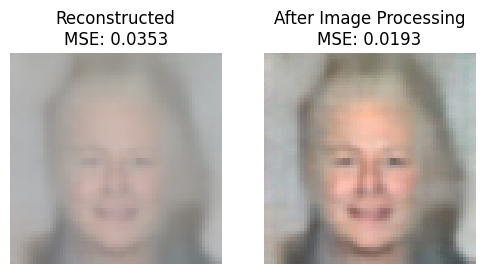

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(6,3))


axs[0].imshow(recon_np)
axs[0].set_title(f"Reconstructed\nMSE: {mse_recon:.4f}")

axs[1].imshow(final_img)
axs[1].set_title(f"After Image Processing\nMSE: {mse_final:.4f}")
for ax in axs:
    ax.axis("off")
plt.show()

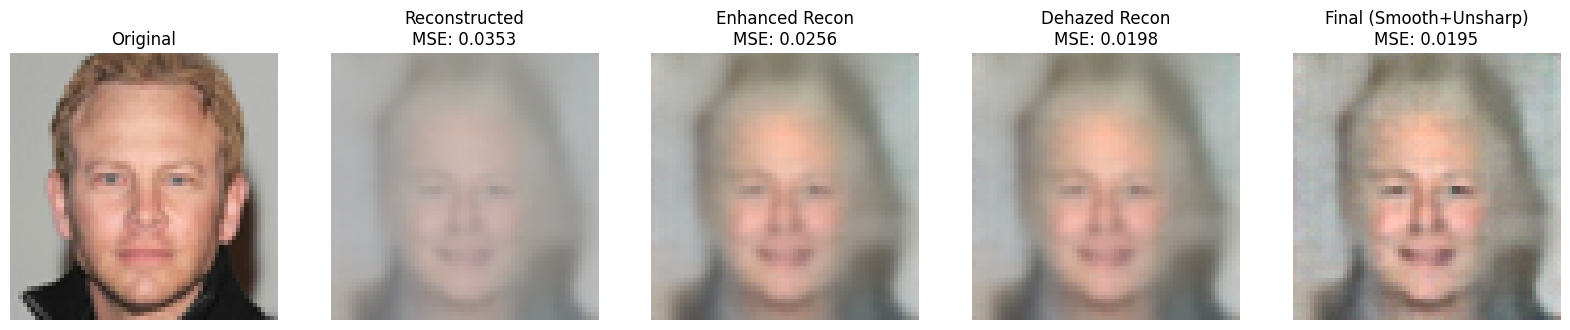

In [ ]:
# ------------------------------
# Dehazed + Enhance + Smooth + Unsharp
# ------------------------------


if isinstance(recon, torch.Tensor):
    recon_np = recon.detach().cpu().numpy().clip(0,1)
else:
    recon_np = recon.clip(0,1)

# --- Dehaze step ---
dehazed_np = dehaze_image(recon_np)   
dehazed_img = Image.fromarray((dehazed_np*255).astype(np.uint8))

# --- Enhance step ---
enhanced_img = enhance_image(dehazed_img, sat=1, contrast=1)

# --- Convert enhanced to numpy (0-1) ---
enhanced_np = np.array(enhanced_img).astype(np.float32) / 255.0

# --- Smoothing step ---
smooth_np = smooth_image(enhanced_np, method="bilateral", kernel_size=3)

# --- Unsharp Masking ---
unsharp_np = unsharp_mask(smooth_np, kernel_size=(5,5), sigma=1.0, amount=4)

# --- Final PIL image ---
final_img = Image.fromarray((unsharp_np*255).astype(np.uint8))

# --- Compute final MSE ---
mse_final = compute_mse(final_img, img_tensor)

# ------------------------------
# Display the differences
# ------------------------------
fig, axs = plt.subplots(1,5, figsize=(20,5))
axs[0].imshow(orig_np)
axs[0].set_title("Original")

axs[1].imshow(recon_np)
axs[1].set_title(f"Reconstructed\nMSE: {mse_recon:.4f}")

axs[2].imshow(enhanced_img)
axs[2].set_title(f"Enhanced Recon\nMSE: {mse_enhanced:.4f}")

axs[3].imshow(dehazed_img)
axs[3].set_title(f"Dehazed Recon\nMSE: {mse_dehazed:.4f}")

axs[4].imshow(final_img)
axs[4].set_title(f"Final (Smooth+Unsharp)\nMSE: {mse_final:.4f}")

for ax in axs:
    ax.axis("off")
plt.show()


# 12) Generate Multiple Reconstructions with StochasticVAE

Here we let the **StochasticVAE** have some fun 🎲.  
Instead of sticking to just one reconstruction, we sample multiple latent codes (`z`) from the same input and decode them into slightly different faces.  

Each generated image then goes through the full post-processing pipeline:  
- **Dehazing** to clear up any fogginess  
- **Enhancement** (contrast & saturation tweaks)  
- **Smoothing** to reduce pixel noise  
- **Unsharp masking** to sharpen edges and bring out details  

Finally, we display the **original face** alongside several generated variants so we can visually inspect the differences.  
This shows the variability of the stochastic model while still keeping the reconstructions faithful to the input.


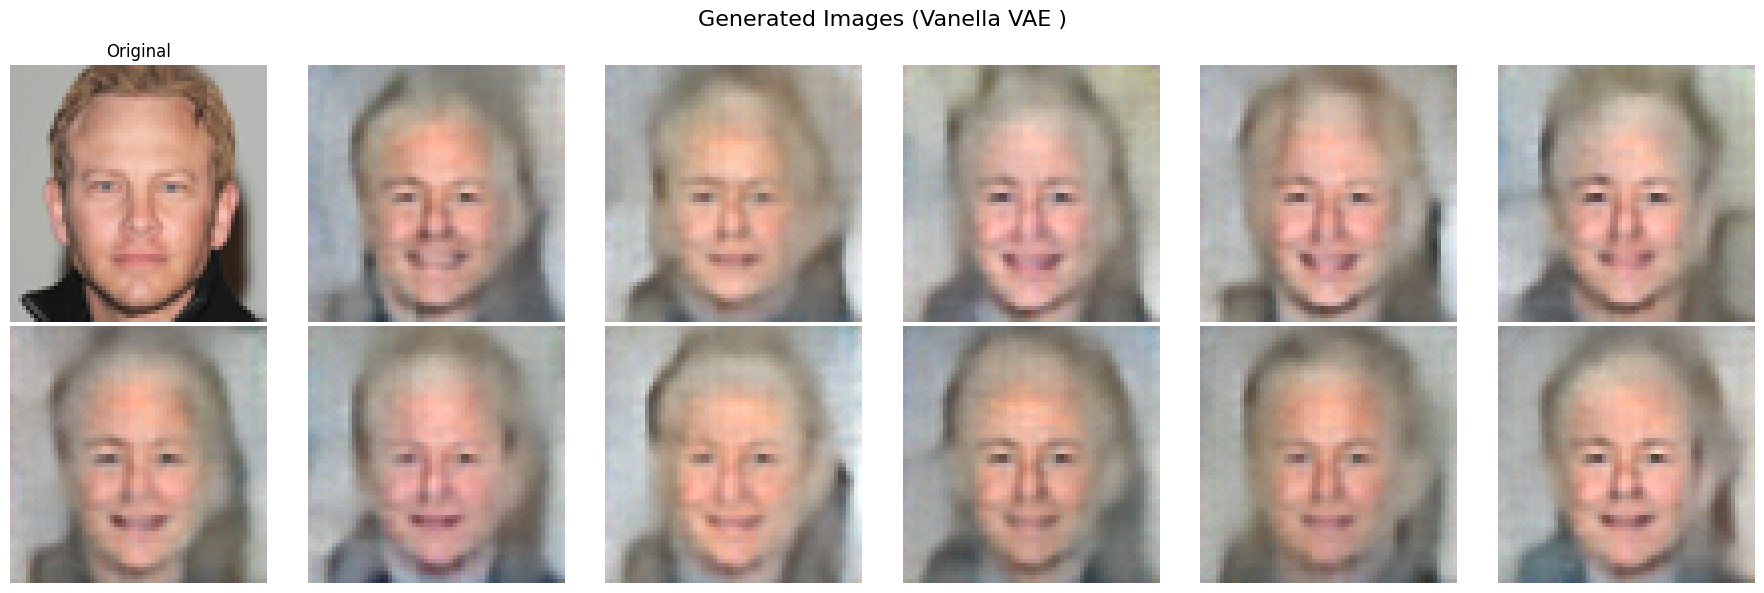

In [ ]:


# -------------------------------
# Generate + Dehaze + Enhance + Sharpen
# -------------------------------
with torch.no_grad():
    mu, log_var = model_Stochastic.encode(img_tensor)
    generated_images = []
    losses = []
    for i in range(11):
        z = model_Stochastic.reparameterize(mu, log_var)
        recon = model_Stochastic.decode(z)

        mse = F.mse_loss(recon, img_tensor).item()
        losses.append(mse)

        recon_np = recon.squeeze(0).permute(1,2,0).cpu().numpy().clip(0,1)

        # --- Dehaze step ---
        recon_np = dehaze_image(recon_np)
        recon_np = Image.fromarray((recon_np*255).astype(np.uint8))

        # --- Enhance step ---
        recon_np = enhance_image(recon_np, sat=1, contrast=1)

        # --- Convert to numpy for Unsharp Masking ---
        recon_np = np.array(recon_np) / 255.0


        recon_np = smooth_image(recon_np, method="bilateral", kernel_size=3)

        recon_np = unsharp_mask(recon_np, kernel_size=(5,5), sigma=1.0, amount=4)

        # PIL image
        final_img = Image.fromarray((recon_np*255).astype(np.uint8))
        generated_images.append(final_img)

# -------------------------------
# Display
# -------------------------------
fig, axs = plt.subplots(2, 6, figsize=(18, 6))
fig.suptitle("Generated Images (Vanella VAE )", fontsize=16)
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])
img_tensor = transform(img).unsqueeze(0).to(next(model.parameters()).device)

# Original resized
img_resized = img.resize((IMAGE_SIZE, IMAGE_SIZE))
axs[0,0].imshow(img_resized)
axs[0,0].set_title("Original")
axs[0,0].axis("off")

# Generated images
for ax, img_gen, loss in zip(axs.flatten()[1:], generated_images, losses):
    ax.imshow(img_gen)

    ax.axis("off")

plt.tight_layout()
plt.show()


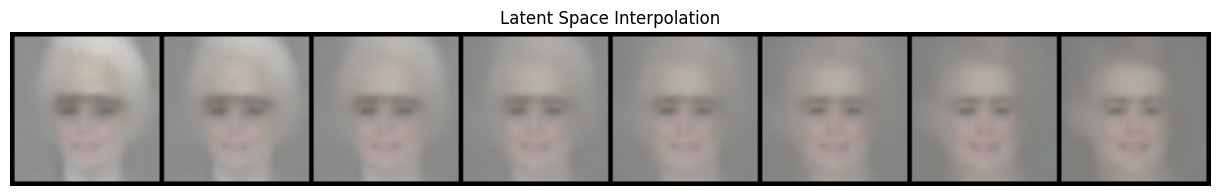

In [ ]:



img = Image.open(img_path).resize((64,64))
img = np.array(img) / 255.0
img_tensor = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
img2_path = "D:/FaceGen-VAE/facegen-env/Scripts/Images/27947.jpg"

img2 = Image.open(img2_path).resize((64,64))
img2 = np.array(img2) / 255.0
img2_tensor = torch.tensor(img2, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

with torch.no_grad():
    mu1, logvar1 = model.encode(img_tensor)
    mu2, logvar2 = model.encode(img2_tensor)

    interpolations = []
    for alpha in np.linspace(0,1,8):
        z = (1-alpha)*mu1 + alpha*mu2
        recon = model.decode(z).reshape(3,64,64)
        interpolations.append(recon)

    grid = make_grid(interpolations, nrow=8)
    plt.figure(figsize=(16,2))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("Latent Space Interpolation")
    plt.show()

# 13) Load Pretrained BetaVAE Model

Now we switch gears and try out a **BetaVAE**, which is a variant of VAE that puts extra weight (β) on the latent regularization term.  
This often leads to more **disentangled latent representations** compared to the vanilla VAE.  

We:  
- Set the latent dimension to 200.  
- Initialize the `BetaVAE` model and move it to the selected device.  
- Load pretrained weights from `100.pt`.  
- Put the model in **evaluation mode** so it’s ready for testing and generation.


In [ ]:
# Loading BetaVAE
LATENT_DIM = 200
model_BetaVAE = BetaVAE(latent_size=LATENT_DIM).to(device)

checkpoint_path = "D:/FaceGen-VAE/facegen-env/Scripts/models/100.pt"
model_BetaVAE.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_BetaVAE.eval()

BetaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fc_mu): Linear(in_features=256, out_features=200, bias=True)
  (fc_var): Linear(in_features=256, out_features=200, bias=True)
  (decoder): Sequential(
    (0): Sequential(


# 14) Generate Images with BetaVAE

Now it’s BetaVAE’s turn to shine ✨.  
We prep the input image, encode it into the latent space, and then repeatedly sample from the latent distribution to decode multiple reconstructions.  

For each sample:  
- We get a slightly different reconstruction thanks to the stochastic sampling.  
- The outputs are clipped and converted back into images for visualization.  

Finally, we show the **original image** next to a grid of generated reconstructions so we can visually compare them.  
This helps us see how BetaVAE handles variability in the latent space compared to the vanilla VAE or the StochasticVAE.


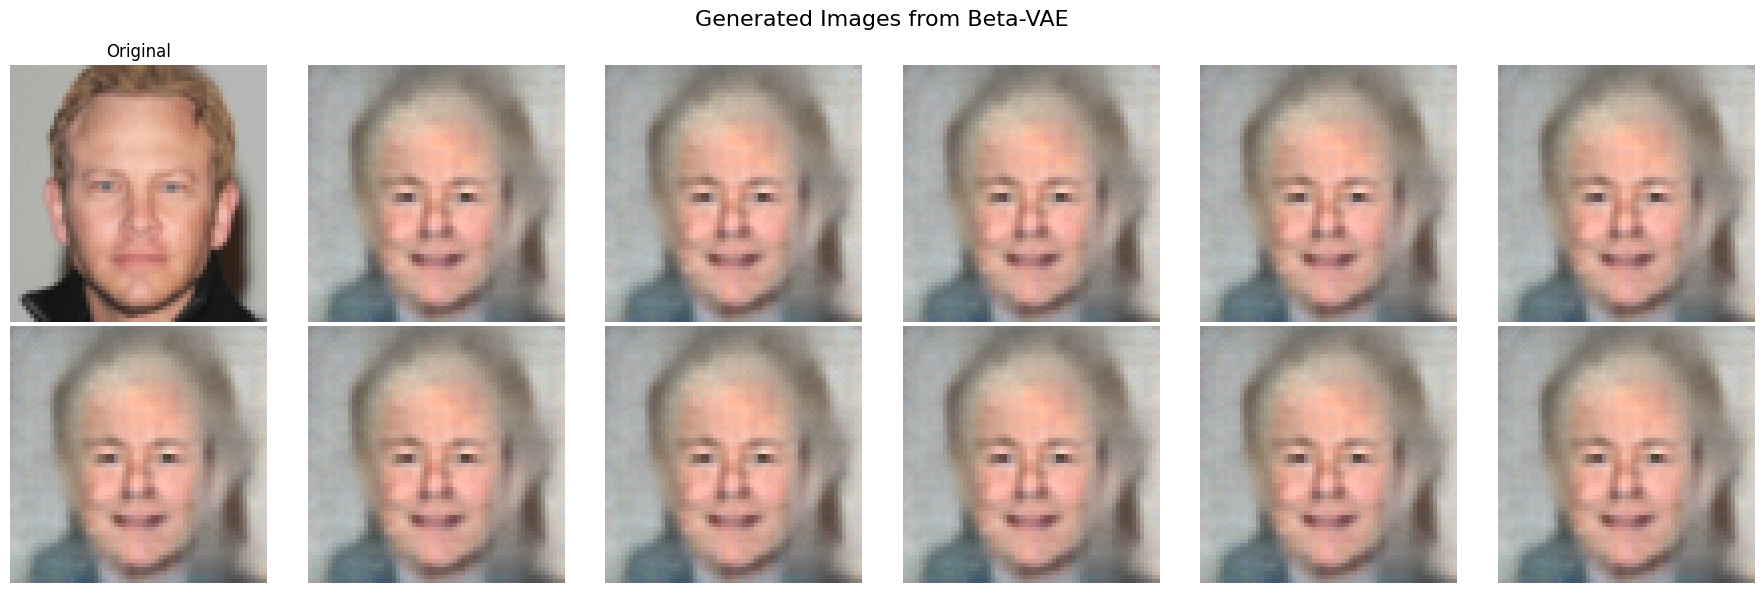

In [ ]:

# image prepration



img_orig = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])
img_tensor = transform(img_orig).unsqueeze(0).to(device)


# MSE function

def mse(img1, img2):
    return ((img1 - img2) ** 2).mean()


# Generate images + compute loss for each one

with torch.no_grad():
    mu, logvar = model_BetaVAE.encode(img_tensor)
    generated_images = []

    img_np_orig = img_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    for i in range(11):
        z = model_BetaVAE.sample(mu, logvar)
        recon = model_BetaVAE.decode(z)
        recon_np = recon.squeeze(0).permute(1,2,0).cpu().numpy().clip(0,1)
        generated_images.append(final_img)


# Display images with loss

fig, axs = plt.subplots(2,6, figsize=(18,6))
fig.suptitle("Generated Images from Beta-VAE", fontsize=16)

# org image
axs[0,0].imshow(img_np_orig)
axs[0,0].set_title("Original")
axs[0,0].axis("off")


for ax, img_gen, loss_val in zip(axs.flatten()[1:], generated_images, losses):
    ax.imshow(img_gen)
    ax.axis("off")

plt.tight_layout()
plt.show()


# 15) Generate Images with DFCVAE

Finally, we try out the **DFCVAE** (Deep Fully Connected VAE).  
This model uses a latent dimension of 100, and we load it from a pretrained checkpoint.  

Steps we take:  
- Prepare the input image and encode it into the latent space.  
- Sample multiple latent vectors and decode them to get different reconstructions.  
- Convert the outputs into images and calculate the **MSE loss** for each one against the original.  

We then display the **original face** alongside a grid of generated reconstructions, each labeled with its MSE score.  
This gives us a clear look at how DFCVAE performs compared to the other VAEs we tested earlier.


Using device: cuda


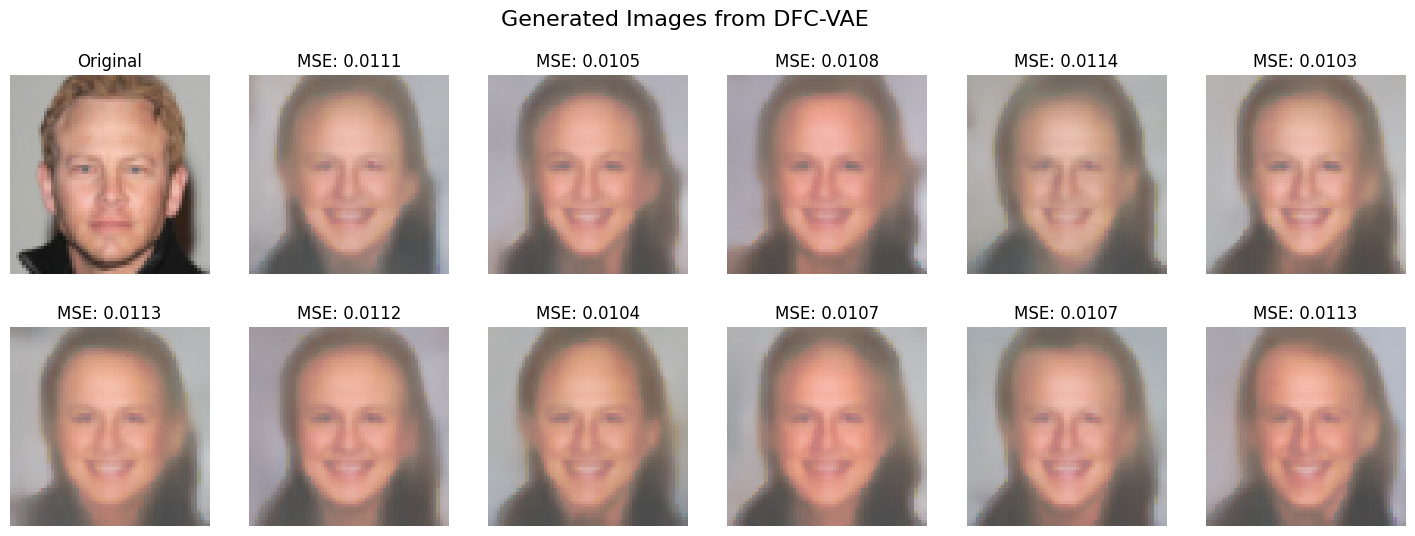

In [ ]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Loading DFCVAE

LATENT_DIM = 100
model = DFCVAE(latent_size=LATENT_DIM).to(device)

checkpoint_path = "D:/FaceGen-VAE/facegen-env/Scripts/models/400.pt"

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Image preparation



img_orig = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])
img_tensor = transform(img_orig).unsqueeze(0).to(device)

# Generate images + compute loss for each one
generated_images = []
losses = []

with torch.no_grad():
    mu, logvar = model.encode(img_tensor)
    for i in range(11):
        z = model.sample(mu, logvar)
        recon = model.decode(z)
        recon_np = recon.squeeze(0).permute(1,2,0).cpu().numpy().clip(0,1)
        recon_img = Image.fromarray((recon_np*255).astype(np.uint8))
        generated_images.append(recon_img)


        mse_loss = F.mse_loss(recon, img_tensor)
        losses.append(mse_loss.item())

# Display images with loss
fig, axs = plt.subplots(2,6, figsize=(18,6))

fig.suptitle("Generated Images from DFC-VAE", fontsize=16)

img_np = img_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
axs[0,0].imshow(img_np)
axs[0,0].set_title("Original")
axs[0,0].axis("off")


for ax, img_gen, loss in zip(axs.flatten()[1:], generated_images, losses):
    ax.imshow(img_gen)
    ax.set_title(f"MSE: {loss:.4f}")
    ax.axis("off")

plt.show()
